In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

seed = 42 #424
np.random.seed(seed)
torch.manual_seed(seed)
#NOTE! This only works for non cudnn. gpu needs
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

from bayes_opt import BayesianOptimization



from helpers import showcase_code
from measures import compute_error

import itertools

In [2]:
showcase = True

# parameter search

1. Bayesian optimization
2. to ensure comparability, we only optimize the simple model that is the base for all the ensembles
3. Optimize once for toy and once for kaggle dataset
4. parameters to optimize:
5. function to be optimized: "an objective function ceases to be a good measuerement of success when it's used as optimization target" or something like that. So we're happy to optimize for error while we're actually interested in things like cobeau and nlpd!






In [3]:

from nn_models.base_model import SimpleModel
showcase_code('nn_models/base_model.py','SimpleModel',showcase)


## toy model optimisation


In [4]:
from data_loaders import get_X_y, generate_y
#showcase_code('data_loaders.py')
toy = True

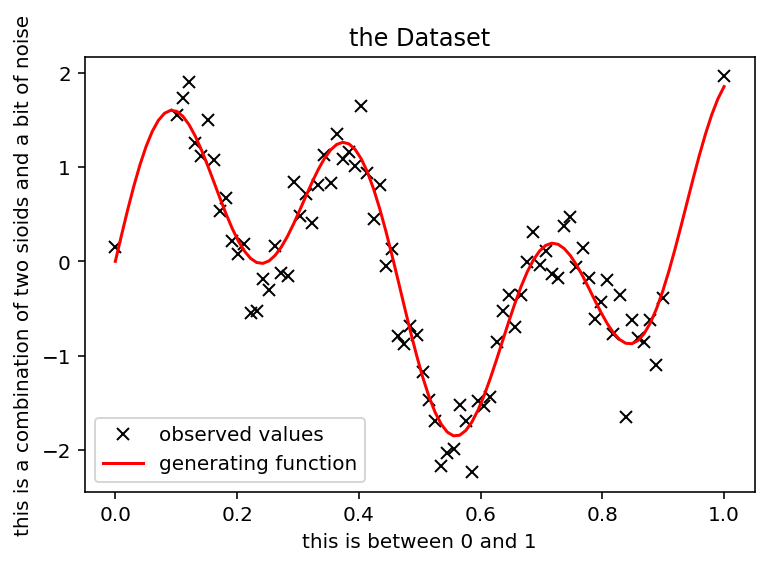

In [5]:
X_train, X_test, y_train, y_test, N, output_dims  = get_X_y(toy,seed=seed)

In [6]:
X_train.shape

(65, 1)

In [7]:
y_train.shape

(65, 1)

In [8]:
def black_box_function(model_provided, decay, num_epochs=2000):
    model = SimpleModel(toy,X_train.shape[1], p=0.0, model_provided=model_provided, decay=decay)
    
    for i in range(num_epochs):
        model.fit_model(X_train,y_train)
        
    y_pred = model(X_test).data.numpy()
    
    plt.plot(X_test,y_test,'x')
    plt.plot(X_test,y_pred,'x')
        
    
    return compute_error(y_test,y_pred)



In [9]:
%%time
#black_box_function(torch.nn.ReLU,0.001)

Wall time: 0 ns


In [10]:
%%time
#black_box_function(torch.nn.LeakyReLU,0.001)

Wall time: 0 ns


In [11]:
non_linearities = [torch.nn.LeakyReLU, torch.nn.ReLU]

# models = 

def make_models(n_dims_input, non_linearity, layer_tuples):
                
        
    layers_list = [[torch.nn.Linear(*layer_tuple), non_linearity()] for layer_tuple in layer_tuples] + [[torch.nn.Dropout(p=0),
    torch.nn.Linear(layer_tuples[-1][1],1)]]
    layers_list = list(itertools.chain.from_iterable(layers_list))

    
    return torch.nn.Sequential(
    torch.nn.Linear(n_dims_input,layer_tuples[0][0]),
    non_linearity(),
        
        
        
    *layers_list
        

    )
    
    #return layers_list

In [12]:
make_models(3,torch.nn.ReLU,[(10,10),(10,4)])

Sequential(
  (0): Linear(in_features=3, out_features=10, bias=True)
  (1): ReLU()
  (2): Linear(in_features=10, out_features=10, bias=True)
  (3): ReLU()
  (4): Linear(in_features=10, out_features=4, bias=True)
  (5): ReLU()
  (6): Dropout(p=0, inplace=False)
  (7): Linear(in_features=4, out_features=1, bias=True)
)

In [13]:
layer_tuple_list = [[(20,20),(20,10),(10,10)],
                    [(20,10),(10,10),(10,10),(10,10)],
                    [(20,50),(50,5),(5,10)],
                    [(10,10),(10,50),(50,10)],
                    [(100,100),(100,10)],
                    ]

In [14]:
models = [make_models(X_train.shape[1],non_linearity, layers) for non_linearity in [torch.nn.LeakyReLU, torch.nn.ReLU, torch.nn.Sigmoid] for layers in layer_tuple_list]

In [ ]:
#models

In [16]:
pbounds = {'model_provided':models, 'decays': (0.0005,0.005)}
#pbounds = { 'decay': (0.0005,0.005)}
seeds = [1, 3, 42, 69, 420, 100, 101, 102, 103, 10]

{'params': {'model': Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=20, out_features=10, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): LeakyReLU(negative_slope=0.01)
  (8): Dropout(p=0, inplace=False)
  (9): Linear(in_features=10, out_features=1, bias=True)
), 'decay': 0.0005}, 'stats': {'outcome_mean': 0.43404328001194514, 'outcome_std': 0.0064825310660185246}}
{'params': {'model': Sequential(
  (0): Linear(in_features=1, out_features=20, bias=True)
  (1): LeakyReLU(negative_slope=0.01)
  (2): Linear(in_features=20, out_features=20, bias=True)
  (3): LeakyReLU(negative_slope=0.01)
  (4): Linear(in_features=20, out_features=10, bias=True)
  (5): LeakyReLU(negative_slope=0.01)
  (6): Linear(in_features=10, out_features=10, bias=True)
  (7): 

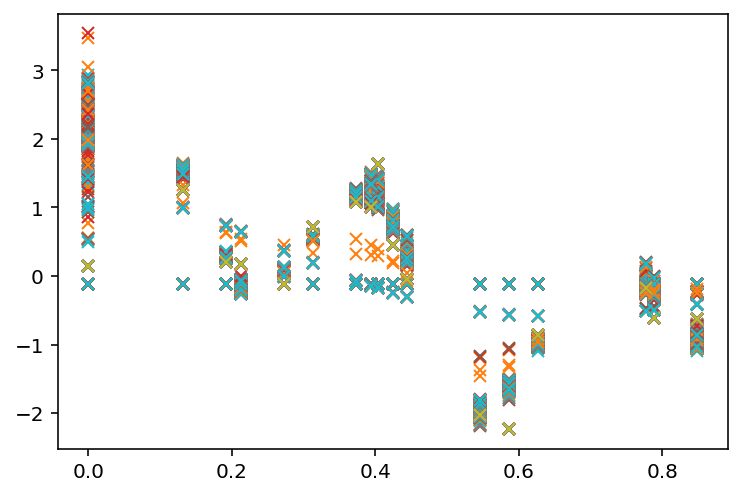

In [19]:
outcome_list = []

for model in pbounds['model_provided']:
    print(model)
    for decay in pbounds['decays']:
        print(decay)
        seed_outcomes = []
        for seed in seeds:
            np.random.seed(seed)
            torch.manual_seed(seed)            
            seed_outcomes.append(black_box_function(model,decay))
            
            
        outcome_mean = np.mean(seed_outcomes)
        outcome_std = np.std(seed_outcomes)
        outcome_dict = {'params':{'model':model,'decay':decay},
                             'stats':{'outcome_mean':outcome_mean,'outcome_std':outcome_std}
                            }
        outcome_list.append(outcome_dict)
        #print(outcome_dict)

        #print(f'for the combination of {non_linearity} and decay {decay}: {np.mean(seed_outcomes), np.std(seed_outcomes)}')


In [20]:
stats = [x['stats'] for x in outcome_list] 

In [21]:
means = [ x['outcome_mean'] for x in stats]
stds = [ x['outcome_std'] for x in stats]

<BarContainer object of 30 artists>

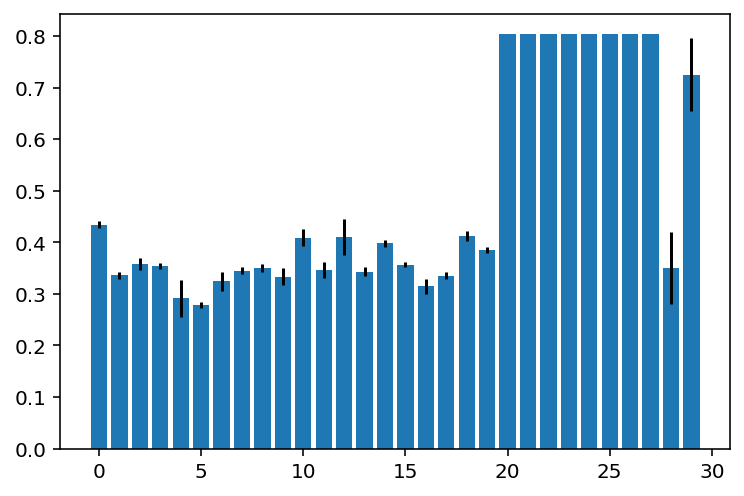

In [22]:
plt.bar(list(range(len(means))),means,yerr=stds)

In [27]:
index = np.argmin(means)

In [28]:
params = [x['params'] for x in outcome_list]

In [29]:
means[index]


0.27845421407518856

In [31]:
stds[index]

0.0050013187484342515

In [33]:
params[index]

{'model': Sequential(
   (0): Linear(in_features=1, out_features=20, bias=True)
   (1): LeakyReLU(negative_slope=0.01)
   (2): Linear(in_features=20, out_features=50, bias=True)
   (3): LeakyReLU(negative_slope=0.01)
   (4): Linear(in_features=50, out_features=5, bias=True)
   (5): LeakyReLU(negative_slope=0.01)
   (6): Linear(in_features=5, out_features=10, bias=True)
   (7): LeakyReLU(negative_slope=0.01)
   (8): Dropout(p=0, inplace=False)
   (9): Linear(in_features=10, out_features=1, bias=True)
 ), 'decay': 0.005}